# Diseño de celda de segundo orden analógico

In [4]:
from scipy import signal

In [5]:
import numpy as np

In [6]:
import matplotlib.pyplot as plt

In [7]:
import seaborn as sns

In [8]:
sns.set_style('dark')
sns.set_context('paper')
sns.set_palette('flare')

In [9]:
# Filter parameters
fo = 4e3
wo = 2 * np.pi * fo
Q = 1

# Coefficients of the filter
a = 1 / wo**2
b = 1 / (Q * wo)

# Second order transfer function
num_a = [0, 1 / wo, 0]
den_a = [a, b, 1]

Hs = signal.TransferFunction(num_a, den_a)

C:\anaconda\lib\site-packages\scipy\signal\filter_design.py:1625: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


In [10]:
w, Hf = signal.freqresp(Hs, w=np.linspace(1, 24e3, 1000) * 2 * np.pi)

In [11]:
t, h = signal.impulse(Hs)

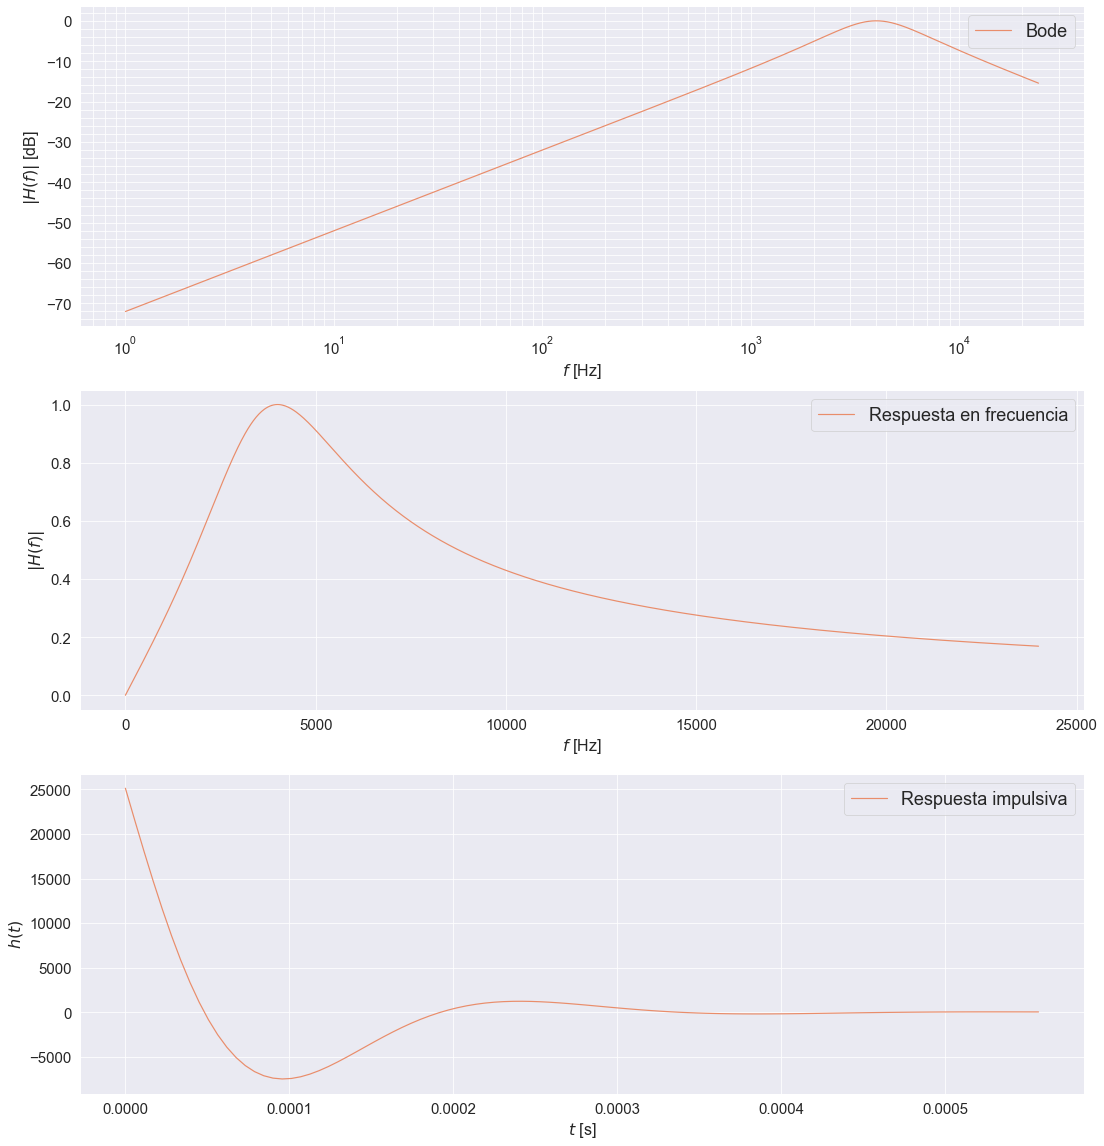

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 20))

ax1.semilogx(w / (2 * np.pi), 20 * np.log10(np.abs(Hf)), label='Bode')
ax1.tick_params(labelsize=15)
ax1.set_ylabel('$|H(f)|$ [dB]', fontsize=16)
ax1.set_xlabel('$f$ [Hz]', fontsize=16)
ax1.minorticks_on()
ax1.legend(fontsize=18)
ax1.grid(which='both')

ax2.plot(w / (2 * np.pi), np.abs(Hf), label='Respuesta en frecuencia')
ax2.tick_params(labelsize=15)
ax2.set_ylabel('$|H(f)|$', fontsize=16)
ax2.set_xlabel('$f$ [Hz]', fontsize=16)
ax2.legend(fontsize=18)
ax2.grid()

ax3.plot(t, h, label='Respuesta impulsiva')
ax3.tick_params(labelsize=15)
ax3.set_ylabel('$h(t)$', fontsize=16)
ax3.set_xlabel('$t$ [s]', fontsize=16)
ax3.legend(fontsize=18)
ax3.grid()

plt.show()

# Diseño del filtro digital IIR 

In [13]:
# Base parameters
fs = 48e3
T = 1 / fs

# Computing the coefficients of the transfer function
mu = 0
sigma = -1
alpha = (b * T) / (4 * a + 2 * b * T + T**2)
gamma = (-1 / 2) * (2 * T**2 - 8 * a) / (4 * a + 2 * b * T + T ** 2)
beta = (1 / 2) * (4 * a - 2 * b * T + T ** 2) / (4 * a + 2 * b * T + T ** 2)

In [14]:
# Print results
print(f'alpha\t\t\tEQU\t\t\t{alpha}')
print(f'beta\t\t\tEQU\t\t\t{beta}')
print(f'gamma\t\t\tEQU\t\t\t{gamma}')
print(f'mu\t\t\tEQU\t\t\t{mu}')
print(f'sigma\t\t\tEQU\t\t\t{sigma}')

alpha			EQU			0.09839579390151451
beta			EQU			0.30320841219697103
gamma			EQU			0.7001685777752599
mu			EQU			0
sigma			EQU			-1


In [15]:
# Create the transfer function in the digital domain
num_d = [alpha, alpha*mu, alpha*sigma]
den_d = [1 / 2, -gamma, beta]
Hz = signal.TransferFunction(num_d, den_d, dt=T)

In [16]:
w, Hf = signal.freqz(num_d, den_d, worN=1024)

<ipython-input-28-b7026ff23b1a>:3: RuntimeWarning: divide by zero encountered in log10
  ax1.semilogx(w * fs / (2 * np.pi), 20 * np.log10(np.abs(Hf)), label='Bode')


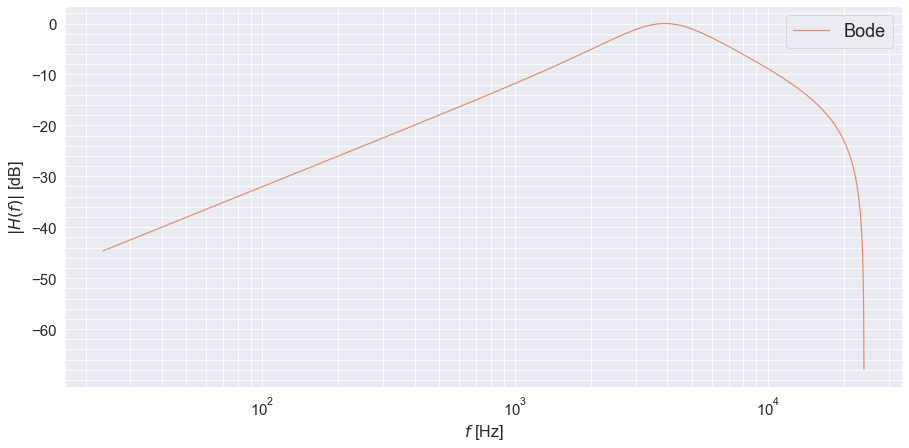

In [28]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 7))

ax1.semilogx(w * fs / (2 * np.pi), 20 * np.log10(np.abs(Hf)), label='Bode')
ax1.tick_params(labelsize=15)
ax1.set_ylabel('$|H(f)|$ [dB]', fontsize=16)
ax1.set_xlabel('$f$ [Hz]', fontsize=16)
ax1.minorticks_on()
ax1.legend(fontsize=18)
ax1.grid(which='both')
ax1.set_yticks(np.linspace(-60, 0, 7))

plt.savefig('ex1a_bode.png')
plt.show()

# Banco de pruebas para IIR

In [18]:
class IIR:

    def __init__(self, alpha, mu, sigma, gamma, beta):
        # Initialize parameters
        self.alpha = alpha
        self.mu = mu
        self.sigma = sigma
        self.gamma = gamma
        self.beta = beta
        
        # Initialize memory buffer
        self.x = np.zeros(2)
        self.y = np.zeros(2)
    
    def run(self, x):
        # Compute new sample of y
        y = 0
        y += self.alpha * x
        y += self.alpha * self.mu * self.x[0]
        y += self.alpha * self.sigma * self.x[1]
        y += self.gamma * self.y[0]
        y += -self.beta * self.y[1]
        y *= 2
        
        # Update memory buffers
        self.x[1] = self.x[0]
        self.x[0] = x
        self.y[1] = self.y[0]
        self.y[0] = y
        
        return y

In [19]:
# How many samples will be ran
N = 40

# Create the impulse signal
x = np.zeros(N)
x[0] = 0.1

In [20]:
# Create the filter
iir = IIR(alpha, mu, sigma, gamma, beta)

In [21]:
y = np.zeros(N)
for i in range(N):
    y[i] = iir.run(x[i])

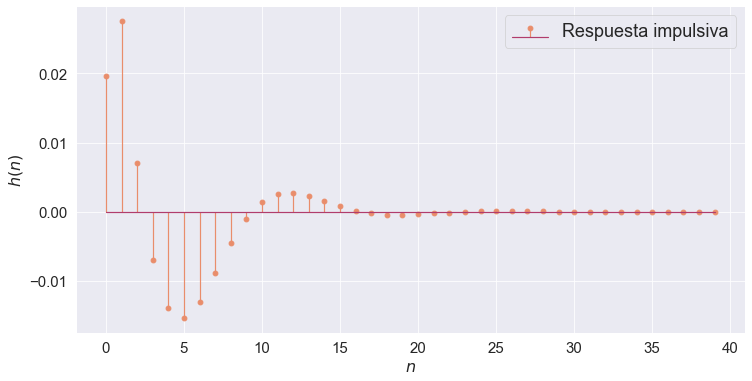

In [30]:
plt.figure(figsize=(12, 6))
plt.xlabel('$n$', fontsize=16)
plt.ylabel('$h(n)$', fontsize=16)
plt.stem(y, label='Respuesta impulsiva')
plt.legend(fontsize=18)
plt.tick_params(labelsize=15)
plt.grid()
plt.savefig('ex1a_respuesta_impulsiva.png')
plt.show()

In [23]:
for i in range(N):
    print(y[i])

0.019679158780302904
0.027557457230036404
0.006976799517115932
-0.006941434111166189
-0.013951196706274442
-0.015326976681756945
-0.013002694526606493
-0.008913619740969403
-0.004597020190338854
-0.001032009200173602
0.0013425495576270543
0.0025058497706276855
0.0026948899007100055
0.0022541649977697426
0.0015223644254385577
0.0007648598896224262
0.00014787432178379437
-0.00025674999822545186
-0.0004492100388281668
-0.0004733479894303448
-0.00039043825187239014
-0.00025969900646149324
-0.00012689784318520655
-2.0213917974827464e-05
4.864668668741199e-05
8.037982280966233e-05
8.30586831786699e-05
6.756648325260724e-05
4.424767407695631e-05
2.0988209847138916e-05
2.5580360768739185e-06
-9.145490601530412e-06
-1.4358006409484128e-05
-1.4560070486728419e-05
-1.1682071038533116e-05
-7.529366421524762e-06
-3.4594471362838867e-06
-2.784578875617431e-07
1.7079320203351734e-06
2.560542215132447e-06
